In [6]:
# ---------------------------------------------------------
# Block 1: Data Loading
# ---------------------------------------------------------

import pandas as pd

# Load dataset
FILE_PATH = "/content/Modified_Frequency_Profile_2024.csv"
df = pd.read_csv(FILE_PATH)

# Display initial rows
df.head(10)


,Date,Time,Frequency
0,2024-01-01,00:00,49.87
1,2024-01-01,00:15,50.45
2,2024-01-01,00:30,50.23
3,2024-01-01,00:45,50.10
4,2024-01-01,01:00,49.66
5,2024-01-01,01:15,49.66
6,2024-01-01,01:30,49.56
7,2024-01-01,01:45,50.37
8,2024-01-01,02:00,50.10
9,2024-01-01,02:15,50.21


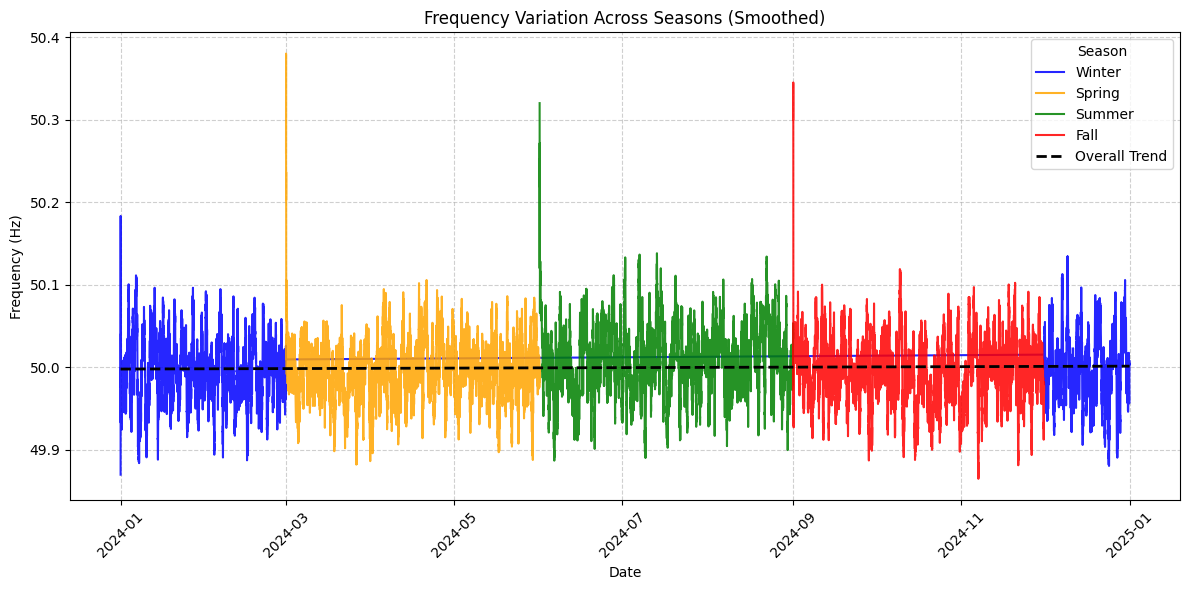

In [7]:
# ---------------------------------------------------------
# Block 2: Datetime Processing, Season Tagging & Visualization
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression

# -------------------------------
# Datetime conversion and sorting
# -------------------------------
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.sort_values(by="Datetime")

# -------------------------------
# Season assignment
# -------------------------------
def get_season(month: int) -> str:
    """Return season name based on month number."""
    if month in (12, 1, 2):
        return "Winter"
    elif month in (3, 4, 5):
        return "Spring"
    elif month in (6, 7, 8):
        return "Summer"
    return "Fall"  # Sep–Nov

df["Season"] = df["Datetime"].dt.month.map(get_season)

# Color mapping
SEASON_COLORS = {
    "Winter": "blue",
    "Spring": "orange",
    "Summer": "green",
    "Fall":   "red"
}

# -------------------------------
# Seasonal Line Plot (Smoothed)
# -------------------------------
plt.figure(figsize=(12, 6))

for season, color in SEASON_COLORS.items():
    season_data = df[df["Season"] == season].copy()
    season_data["Smoothed_Frequency"] = (
        season_data["Frequency"].rolling(window=50, min_periods=1).mean()
    )

    plt.plot(
        season_data["Datetime"],
        season_data["Smoothed_Frequency"],
        label=season,
        color=color,
        alpha=0.85
    )

# -------------------------------
# Trendline using Linear Regression
# -------------------------------
X = np.array(df.index).reshape(-1, 1)
y = df["Frequency"].values

trend_model = LinearRegression()
trend_model.fit(X, y)
trendline = trend_model.predict(X)

plt.plot(
    df["Datetime"],
    trendline,
    color="black",
    linewidth=2,
    linestyle="dashed",
    label="Overall Trend"
)

# -------------------------------
# Plot formatting
# -------------------------------
plt.xlabel("Date")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency Variation Across Seasons (Smoothed)")
plt.legend(title="Season", loc="upper right")
plt.grid(True, linestyle="--", alpha=0.6)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


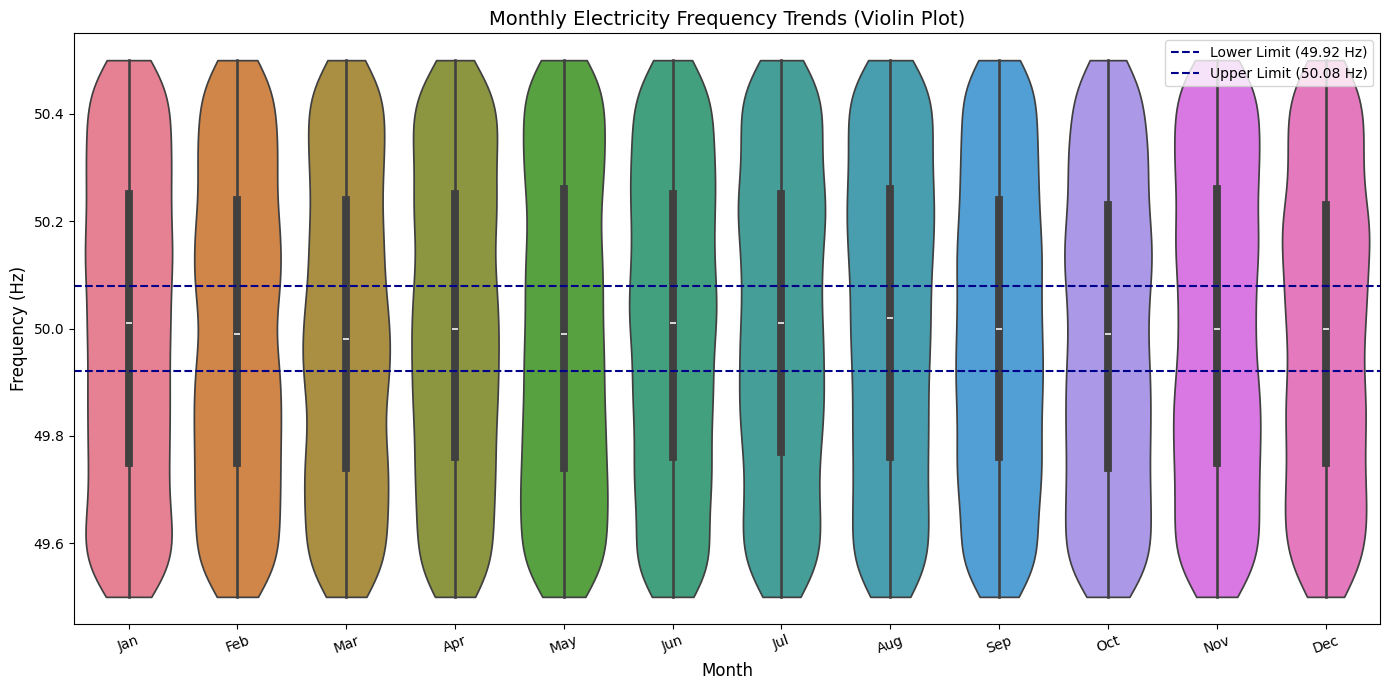

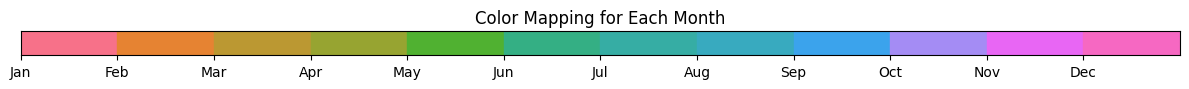

In [8]:
# ---------------------------------------------------------
# Block 3: Monthly Frequency Distribution (Violin Plot)
# ---------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Month extraction from Date
# -------------------------------
df["Date"] = pd.to_datetime(df["Date"])
df["Month"] = df["Date"].dt.strftime("%B")

# Chronological month order
MONTH_ORDER = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Distinct color palette for 12 months
MONTH_COLORS = sns.color_palette("husl", 12)

# -------------------------------
# Violin Plot
# -------------------------------
plt.figure(figsize=(14, 7))

sns.violinplot(
    x="Month",
    y="Frequency",
    data=df,
    order=MONTH_ORDER,
    hue="Month",
    palette=MONTH_COLORS,
    width=0.8,
    cut=0,           # No outliers outside range
    legend=False
)

# Acceptable frequency range lines
plt.axhline(49.92, color="darkblue", linestyle="dashed", label="Lower Limit (49.92 Hz)")
plt.axhline(50.08, color="darkblue", linestyle="dashed", label="Upper Limit (50.08 Hz)")

# Clean month labels
plt.xticks(
    ticks=range(12),
    labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
            "Aug", "Sep", "Oct", "Nov", "Dec"],
    rotation=20
)

# Title and labels
plt.xlabel("Month", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.title("Monthly Electricity Frequency Trends (Violin Plot)", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Color Legend for Months
# -------------------------------
fig, ax = plt.subplots(figsize=(12, 1))

for i, color in enumerate(MONTH_COLORS):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

ax.set_xticks(range(12))
ax.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul",
     "Aug", "Sep", "Oct", "Nov", "Dec"],
    fontsize=10
)

ax.set_yticks([])
ax.set_xlim(0, 12)
ax.set_title("Color Mapping for Each Month", fontsize=12)

plt.tight_layout()
plt.show()


/tmp/ipython-input-2508005916.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


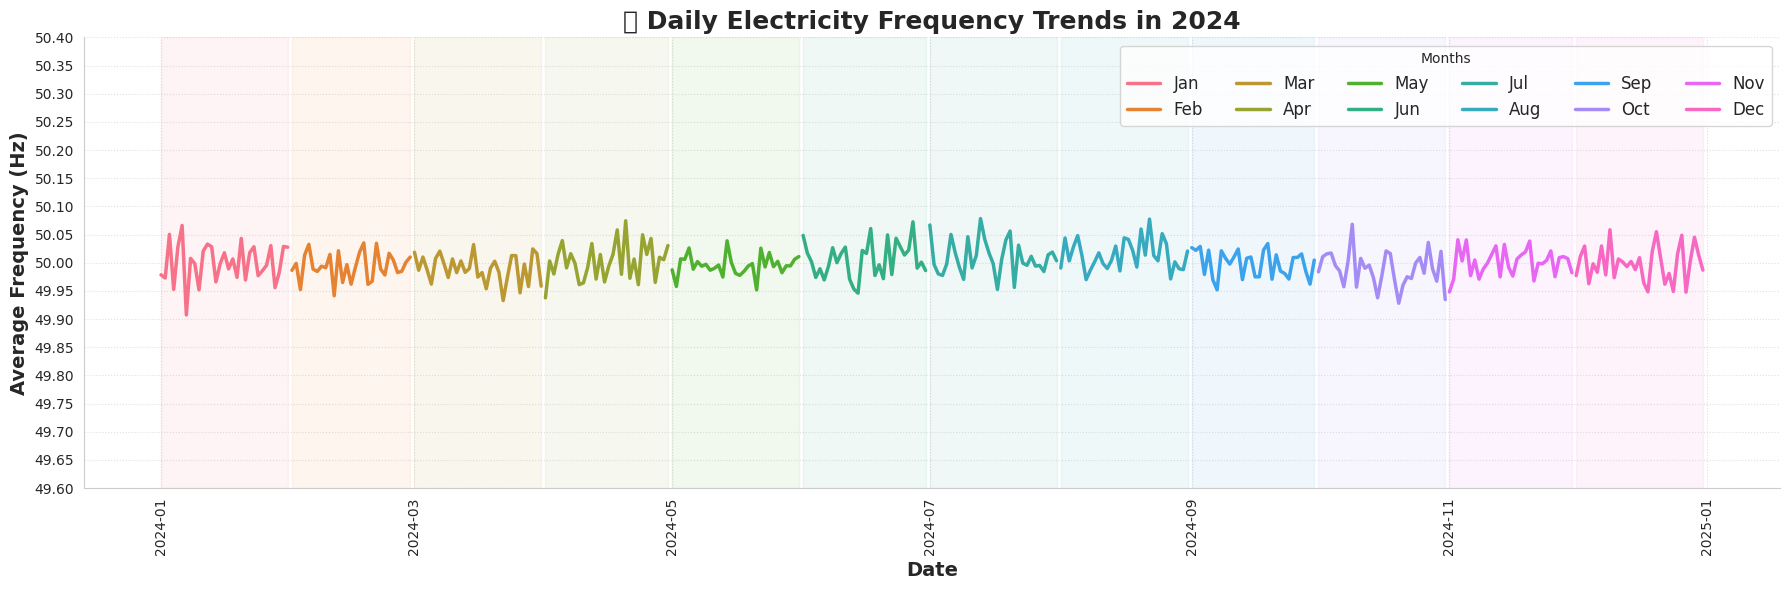

In [9]:
# ---------------------------------------------------------
# Block 4: Daily Frequency Trend with Monthly Shading
# ---------------------------------------------------------

# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"])

# Extract month number
df["Month"] = df["Date"].dt.month

# Daily mean frequency (grouped by Date & Month)
df_daily = (
    df.groupby(["Date", "Month"])["Frequency"]
      .mean()
      .reset_index()
)

# Month names & color palette
MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

PALETTE = sns.color_palette("husl", 12)

# Seaborn visual theme
sns.set_style("whitegrid")

# -------------------------------
# Plot Setup
# -------------------------------
plt.figure(figsize=(18, 6))

# Background shading for each month
for month in range(1, 13):
    month_data = df_daily[df_daily["Month"] == month]
    if not month_data.empty:
        plt.axvspan(
            month_data["Date"].min(),
            month_data["Date"].max(),
            color=PALETTE[month - 1],
            alpha=0.08
        )

# Main daily line plot
sns.lineplot(
    data=df_daily,
    x="Date",
    y="Frequency",
    hue="Month",
    palette=PALETTE,
    linewidth=2.5
)

# -------------------------------
# Formatting & Styling
# -------------------------------
plt.xticks(rotation=90, fontsize=10)
plt.yticks(np.arange(49.6, 50.45, 0.05))
plt.ylim(49.6, 50.4)

plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("Average Frequency (Hz)", fontsize=14, fontweight="bold")
plt.title("📊 Daily Electricity Frequency Trends in 2024", fontsize=18, fontweight="bold")

# Legend update (Replace month numbers with month names)
handles, labels = plt.gca().get_legend_handles_labels()
labels = MONTH_NAMES
plt.legend(
    handles,
    labels,
    title="Months",
    ncol=6,
    fontsize=12,
    loc="upper right",
    frameon=True
)

# Clean aesthetics
plt.grid(True, linestyle="dotted", alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()


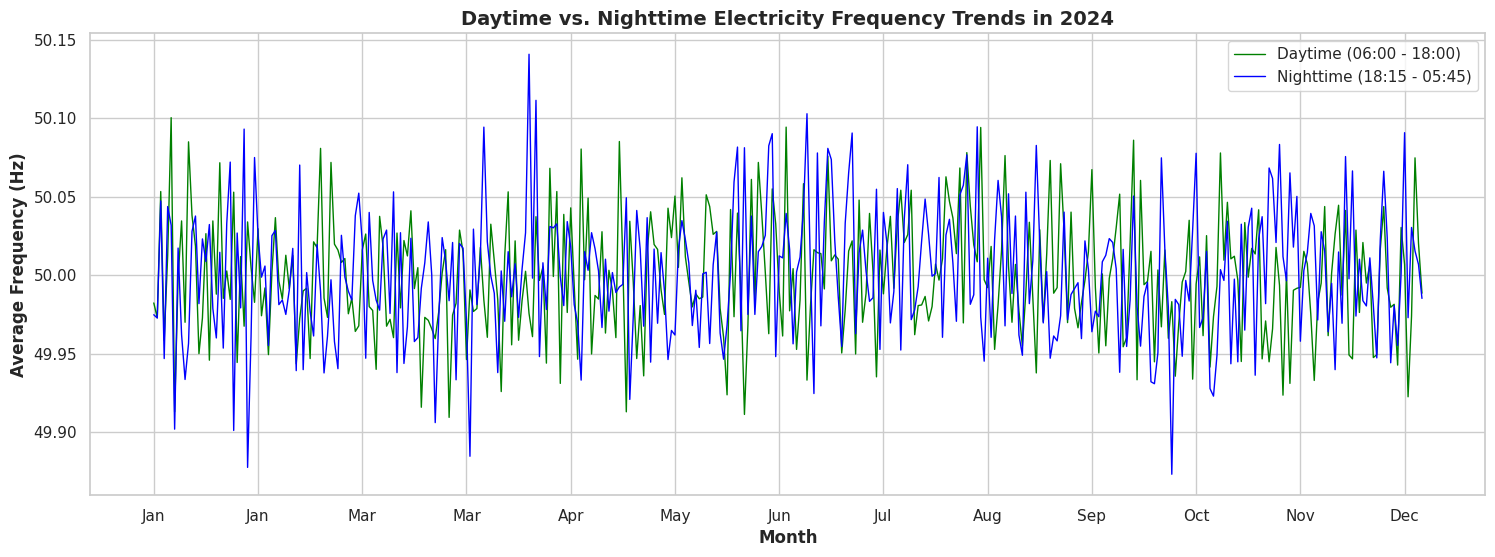

In [10]:
df["DateTime"] = pd.to_datetime(df["Date"].astype(str) + " " + df["Time"]) # Combining Date and Time
df["Month"] = df["DateTime"].dt.strftime("%b")  # Extract month as short name (Jan, Feb, etc.)
df["Time"] = df["DateTime"].dt.strftime("%H:%M")  # Extract time in HH:MM format

# Define daytime and nighttime periods
daytime_hours = [f"{h:02d}:{m:02d}" for h in range(6, 18) for m in [0, 15, 30, 45]]
nighttime_hours = [f"{h:02d}:{m:02d}" for h in range(18, 24) for m in [0, 15, 30, 45]] + \
                  [f"{h:02d}:{m:02d}" for h in range(0, 6) for m in [0, 15, 30, 45]]

# Separate daytime and nighttime frequency averages per day
df_daytime = df[df["Time"].isin(daytime_hours)].groupby("Date")["Frequency"].mean().reset_index()
df_nighttime = df[df["Time"].isin(nighttime_hours)].groupby("Date")["Frequency"].mean().reset_index()

# Merge both datasets for plotting
df_combined = df_daytime.merge(df_nighttime, on="Date", suffixes=("_Daytime", "_Nighttime"))

# Convert "Date" column to datetime for correct ordering
df_combined["Date"] = pd.to_datetime(df_combined["Date"])

# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create a larger, more readable figure
plt.figure(figsize=(18, 6))

# Plot daytime vs. nighttime frequency trends
plt.plot(df_combined["Date"], df_combined["Frequency_Daytime"], label="Daytime (06:00 - 18:00)", color="green", linewidth=1)
plt.plot(df_combined["Date"], df_combined["Frequency_Nighttime"], label="Nighttime (18:15 - 05:45)", color="blue", linewidth=1)

# Format x-axis to display months
# Format x-axis to display months
#plt.xticks(df_combined["Date"][::30], df_combined["Date"].dt.strftime('%b'), rotation=0)  # Showing only month names
# The above line is replaced with the below line as it attempts to apply 366 labels to only 13 tick positions.
plt.xticks(
    ticks=df_combined["Date"][::30],  # Tick positions (every 30 days)
    labels=df_combined["Date"][::30].dt.strftime('%b'),  # Corresponding month labels
    rotation=0  # No rotation
)

# Formatting
plt.xlabel("Month", fontsize=12, fontweight='bold')
plt.ylabel("Average Frequency (Hz)", fontsize=12, fontweight='bold')
plt.title("Daytime vs. Nighttime Electricity Frequency Trends in 2024", fontsize=14, fontweight='bold')

# Show the legend
plt.legend()

# Show the plot
plt.show()


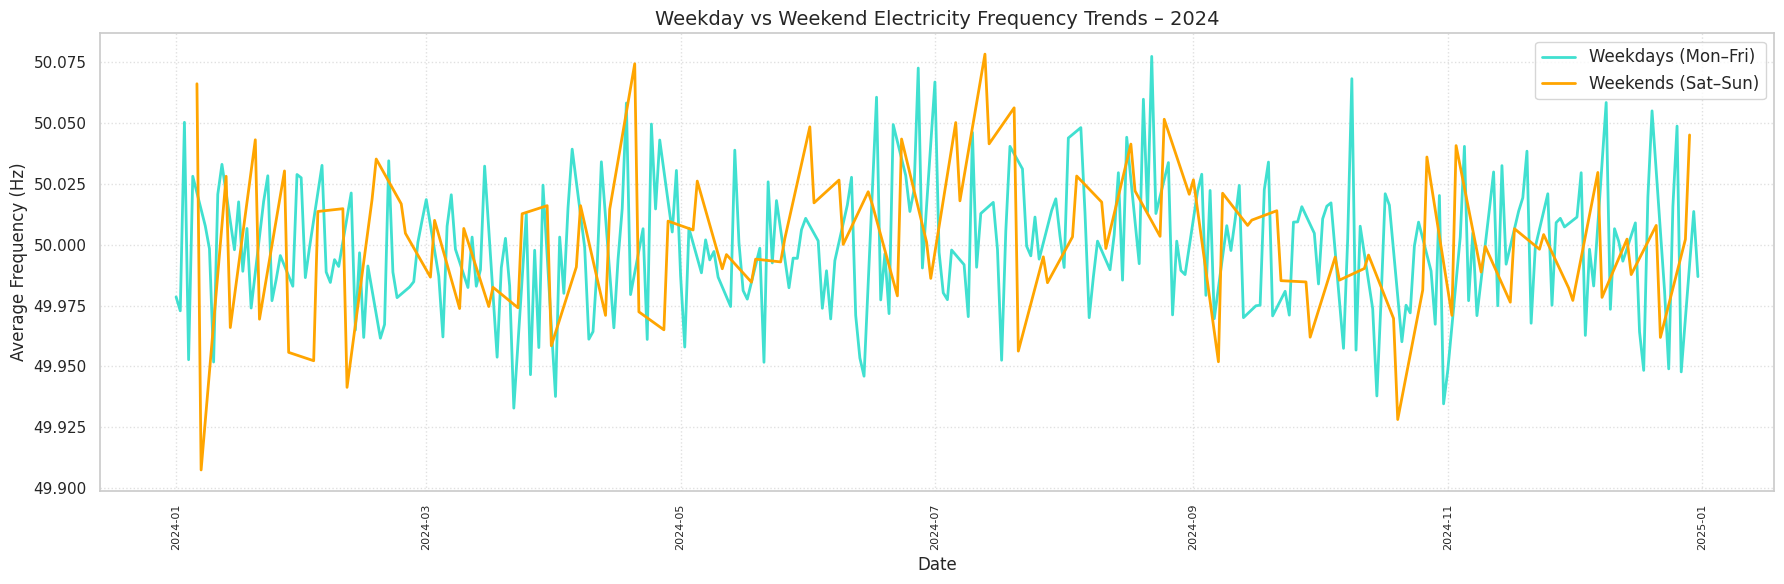

In [11]:
# ---------------------------------------------------------
# Block 5: Weekday vs Weekend Frequency Trend
# ---------------------------------------------------------

# Daily average frequency across the year
df_overall = (
    df.groupby("Date")["Frequency"]
      .mean()
      .reset_index()
)

# Extract day of week (0 = Monday … 6 = Sunday)
df_overall["DayOfWeek"] = pd.to_datetime(df_overall["Date"]).dt.dayofweek

# Split into weekdays & weekends
df_weekdays = df_overall[df_overall["DayOfWeek"] < 5]   # Mon–Fri
df_weekends = df_overall[df_overall["DayOfWeek"] >= 5]  # Sat–Sun

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(18, 6))

plt.plot(
    df_weekdays["Date"], df_weekdays["Frequency"],
    label="Weekdays (Mon–Fri)",
    color="turquoise",
    linestyle="-",
    linewidth=2
)

plt.plot(
    df_weekends["Date"], df_weekends["Frequency"],
    label="Weekends (Sat–Sun)",
    color="orange",
    linestyle="-",
    linewidth=2
)

# Formatting
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Average Frequency (Hz)", fontsize=12)
plt.title("Weekday vs Weekend Electricity Frequency Trends – 2024", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="dotted", alpha=0.6)

plt.tight_layout()
plt.show()



Mean Squared Error (MSE): 0.0008141009



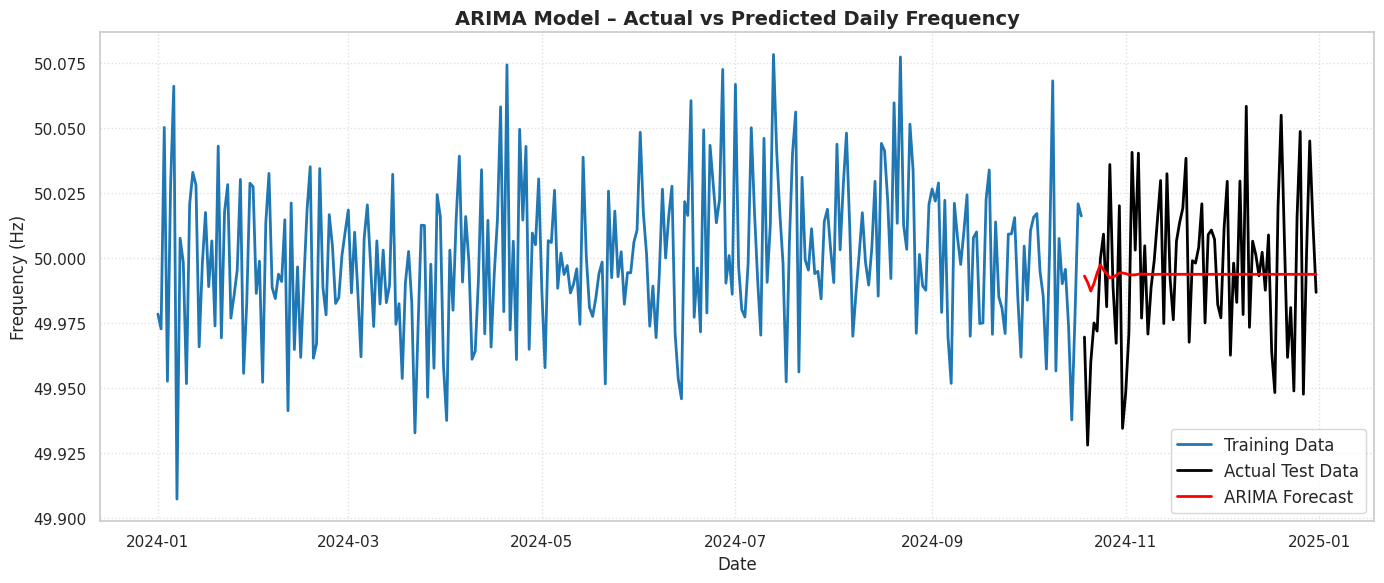

In [12]:
# ---------------------------------------------------------
# Block 6: ARIMA Model – Training, Forecasting & Evaluation
# ---------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")   # Keep output clean

# -------------------------------
# Load Dataset
# -------------------------------
FILE_PATH = "Modified_Frequency_Profile_2024.csv"
df = pd.read_csv(FILE_PATH)

# Ensure Date is datetime and set as index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

# -------------------------------
# Daily Resampling (D = Daily)
# -------------------------------
df_daily = df["Frequency"].resample("D").mean()

# -------------------------------
# Train-Test Split (80/20)
# -------------------------------
train_size = int(len(df_daily) * 0.80)
train = df_daily.iloc[:train_size]
test  = df_daily.iloc[train_size:]

# -------------------------------
# ARIMA Model (Manual p,d,q)
# -------------------------------
model = ARIMA(train, order=(5, 1, 5))
model_fit = model.fit()

# -------------------------------
# Forecasting
# -------------------------------
predictions = model_fit.forecast(steps=len(test))

# -------------------------------
# Evaluation Metric
# -------------------------------
mse = mean_squared_error(test, predictions)
print(f"\nMean Squared Error (MSE): {mse:.10f}\n")

# -------------------------------
# Plot Actual vs Predicted
# -------------------------------
plt.figure(figsize=(14, 6))

plt.plot(train.index, train, label="Training Data", color="#1f77b4", linewidth=2)
plt.plot(test.index, test, label="Actual Test Data", color="black", linewidth=2)
plt.plot(test.index, predictions, label="ARIMA Forecast", color="red", linewidth=2)

plt.title("ARIMA Model – Actual vs Predicted Daily Frequency", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="dotted", alpha=0.6)

plt.tight_layout()
plt.show()


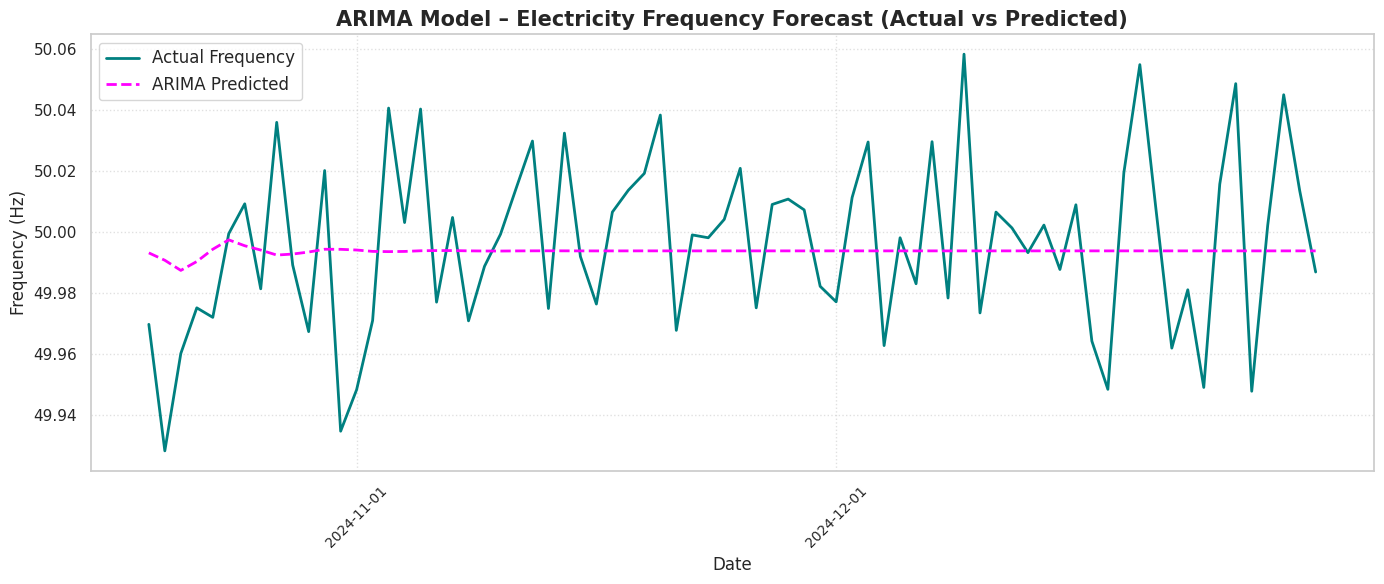

In [14]:
# ---------------------------------------------------------
# Block 7: Final Forecast Plot – Actual vs Predicted
# ---------------------------------------------------------

plt.figure(figsize=(14, 6))

# Actual test data
plt.plot(
    test.index, test,
    label="Actual Frequency",
    color="teal",
    linestyle="-",
    linewidth=2
)

# ARIMA predictions
plt.plot(
    test.index, predictions,
    label="ARIMA Predicted",
    color="magenta",
    linestyle="dashed",
    linewidth=2
)

# Format X-axis (show month start only)
plt.xticks(
    pd.date_range(start=test.index.min(), end=test.index.max(), freq="MS"),
    rotation=45,
    fontsize=10
)

# Labels & title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)
plt.title("ARIMA Model – Electricity Frequency Forecast (Actual vs Predicted)",
          fontsize=15, fontweight="bold")

plt.legend(fontsize=12)
plt.grid(True, linestyle="dotted", alpha=0.6)

plt.tight_layout()
plt.show()


In [15]:
# ---------------------------------------------------------
# Block 8: AR(2) Model – Training & Evaluation
# ---------------------------------------------------------

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# -------------------------------
# AR(2) Model  → (p=2, d=0, q=0)
# -------------------------------
model_ar2 = ARIMA(train, order=(2, 0, 0))
model_ar2_fit = model_ar2.fit()

# -------------------------------
# Forecast using AR(2)
# -------------------------------
predictions_ar2 = model_ar2_fit.forecast(steps=len(test))

# -------------------------------
# Evaluation (MSE)
# -------------------------------
mse_ar2 = mean_squared_error(test, predictions_ar2)
print(f"AR(2) Model MSE: {mse_ar2:.10f}")

mse_ar2


AR(2) Model MSE: 0.0008391784


0.0008391783904419272

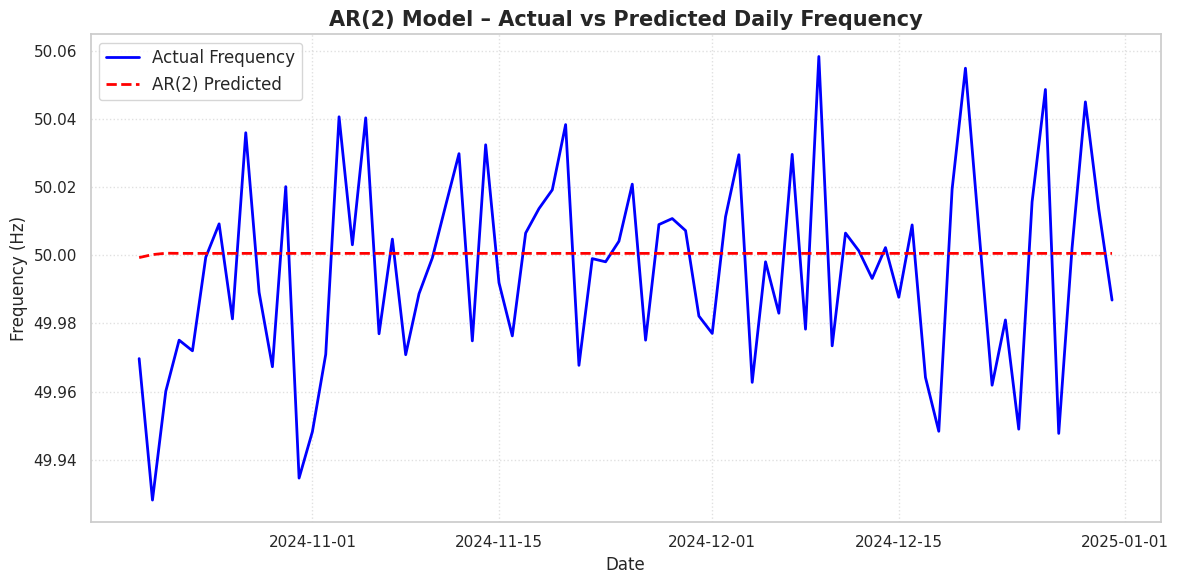

Mean Squared Error (AR(2) Model): 0.0008391784


In [16]:
# ---------------------------------------------------------
# Block 9: AR(2) – Actual vs Predicted Plot
# ---------------------------------------------------------

plt.figure(figsize=(12, 6))

# Actual test data
plt.plot(
    test.index, test,
    label="Actual Frequency",
    color="blue",
    linewidth=2
)

# AR(2) predictions
plt.plot(
    test.index, predictions_ar2,
    label="AR(2) Predicted",
    color="red",
    linestyle="--",
    linewidth=2
)

plt.title("AR(2) Model – Actual vs Predicted Daily Frequency", fontsize=15, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Frequency (Hz)", fontsize=12)

plt.legend(fontsize=12)
plt.grid(True, linestyle="dotted", alpha=0.6)

plt.tight_layout()
plt.show()

# Display MSE
print(f"Mean Squared Error (AR(2) Model): {mse_ar2:.10f}")


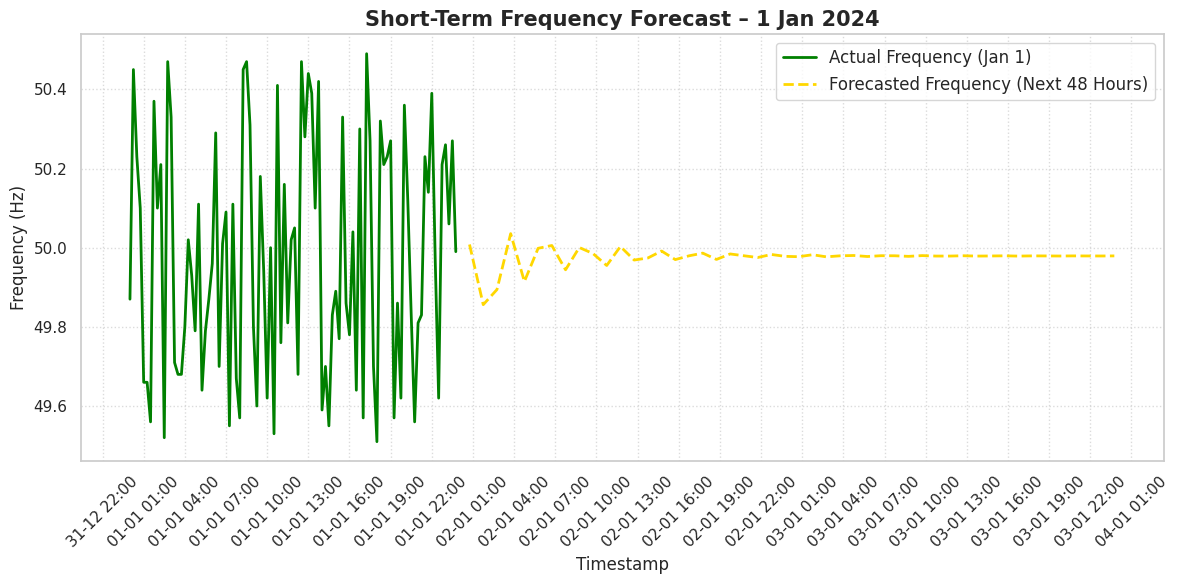

In [17]:
# ---------------------------------------------------------
# Block 10: Short-Term Forecasting for Jan 1st, 2024 (ARIMA)
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

# -------------------------------
# Load and Prepare Dataset
# -------------------------------
df = pd.read_csv("/content/Modified_Frequency_Profile_2024.csv")

df["Timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.sort_values(by="Timestamp")

# Select data for Jan 1, 2024
jan1_data = df[df["Date"] == "2024-01-01"]
training_data = jan1_data["Frequency"].values.reshape(-1, 1)

# -------------------------------
# Normalization (MinMax Scaling)
# -------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler.fit_transform(training_data).flatten()

# -------------------------------
# ARIMA Model (p,d,q)
# -------------------------------
model = ARIMA(training_scaled, order=(5, 1, 5))
model_fit = model.fit()

# -------------------------------
# Forecast Next 48 Hours
# -------------------------------
forecast_steps = 48
forecast_scaled = model_fit.forecast(steps=forecast_steps)

# Inverse scaling to actual frequency values
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

# -------------------------------
# Generate Future Timestamps
# -------------------------------
last_timestamp = jan1_data["Timestamp"].iloc[-1]
future_timestamps = pd.date_range(
    last_timestamp, periods=forecast_steps + 1, freq="H"
)[1:]

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(12, 6))

# Actual Jan 1st frequency
plt.plot(
    jan1_data["Timestamp"],
    training_data,
    label="Actual Frequency (Jan 1)",
    color="green",
    linewidth=2
)

# Forecast curve
plt.plot(
    future_timestamps,
    forecast,
    label="Forecasted Frequency (Next 48 Hours)",
    color="gold",
    linestyle="--",
    linewidth=2
)

plt.title("Short-Term Frequency Forecast – 1 Jan 2024", fontsize=15, fontweight="bold")
plt.xlabel("Timestamp")
plt.ylabel("Frequency (Hz)")
plt.legend(fontsize=12)
plt.grid(True, linestyle=":", alpha=0.7)

# X-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d-%m %H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
